In [132]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, mean_squared_error as mse
from PIL import Image
import random

import pandas as pd
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.kernel_approximation import RBFSampler

# Helper functions for RMSE and PSNR
def np_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

def np_psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    max_pixel = 1.0  # Assume the image is normalized
    return 20 * np.log10(max_pixel / np.sqrt(mse))

# Generate a sample image (let's create a 30x30 grayscale image)
np.random.seed(42)



%matplotlib inline
%config InlineBackend.figure_format = 'retina'


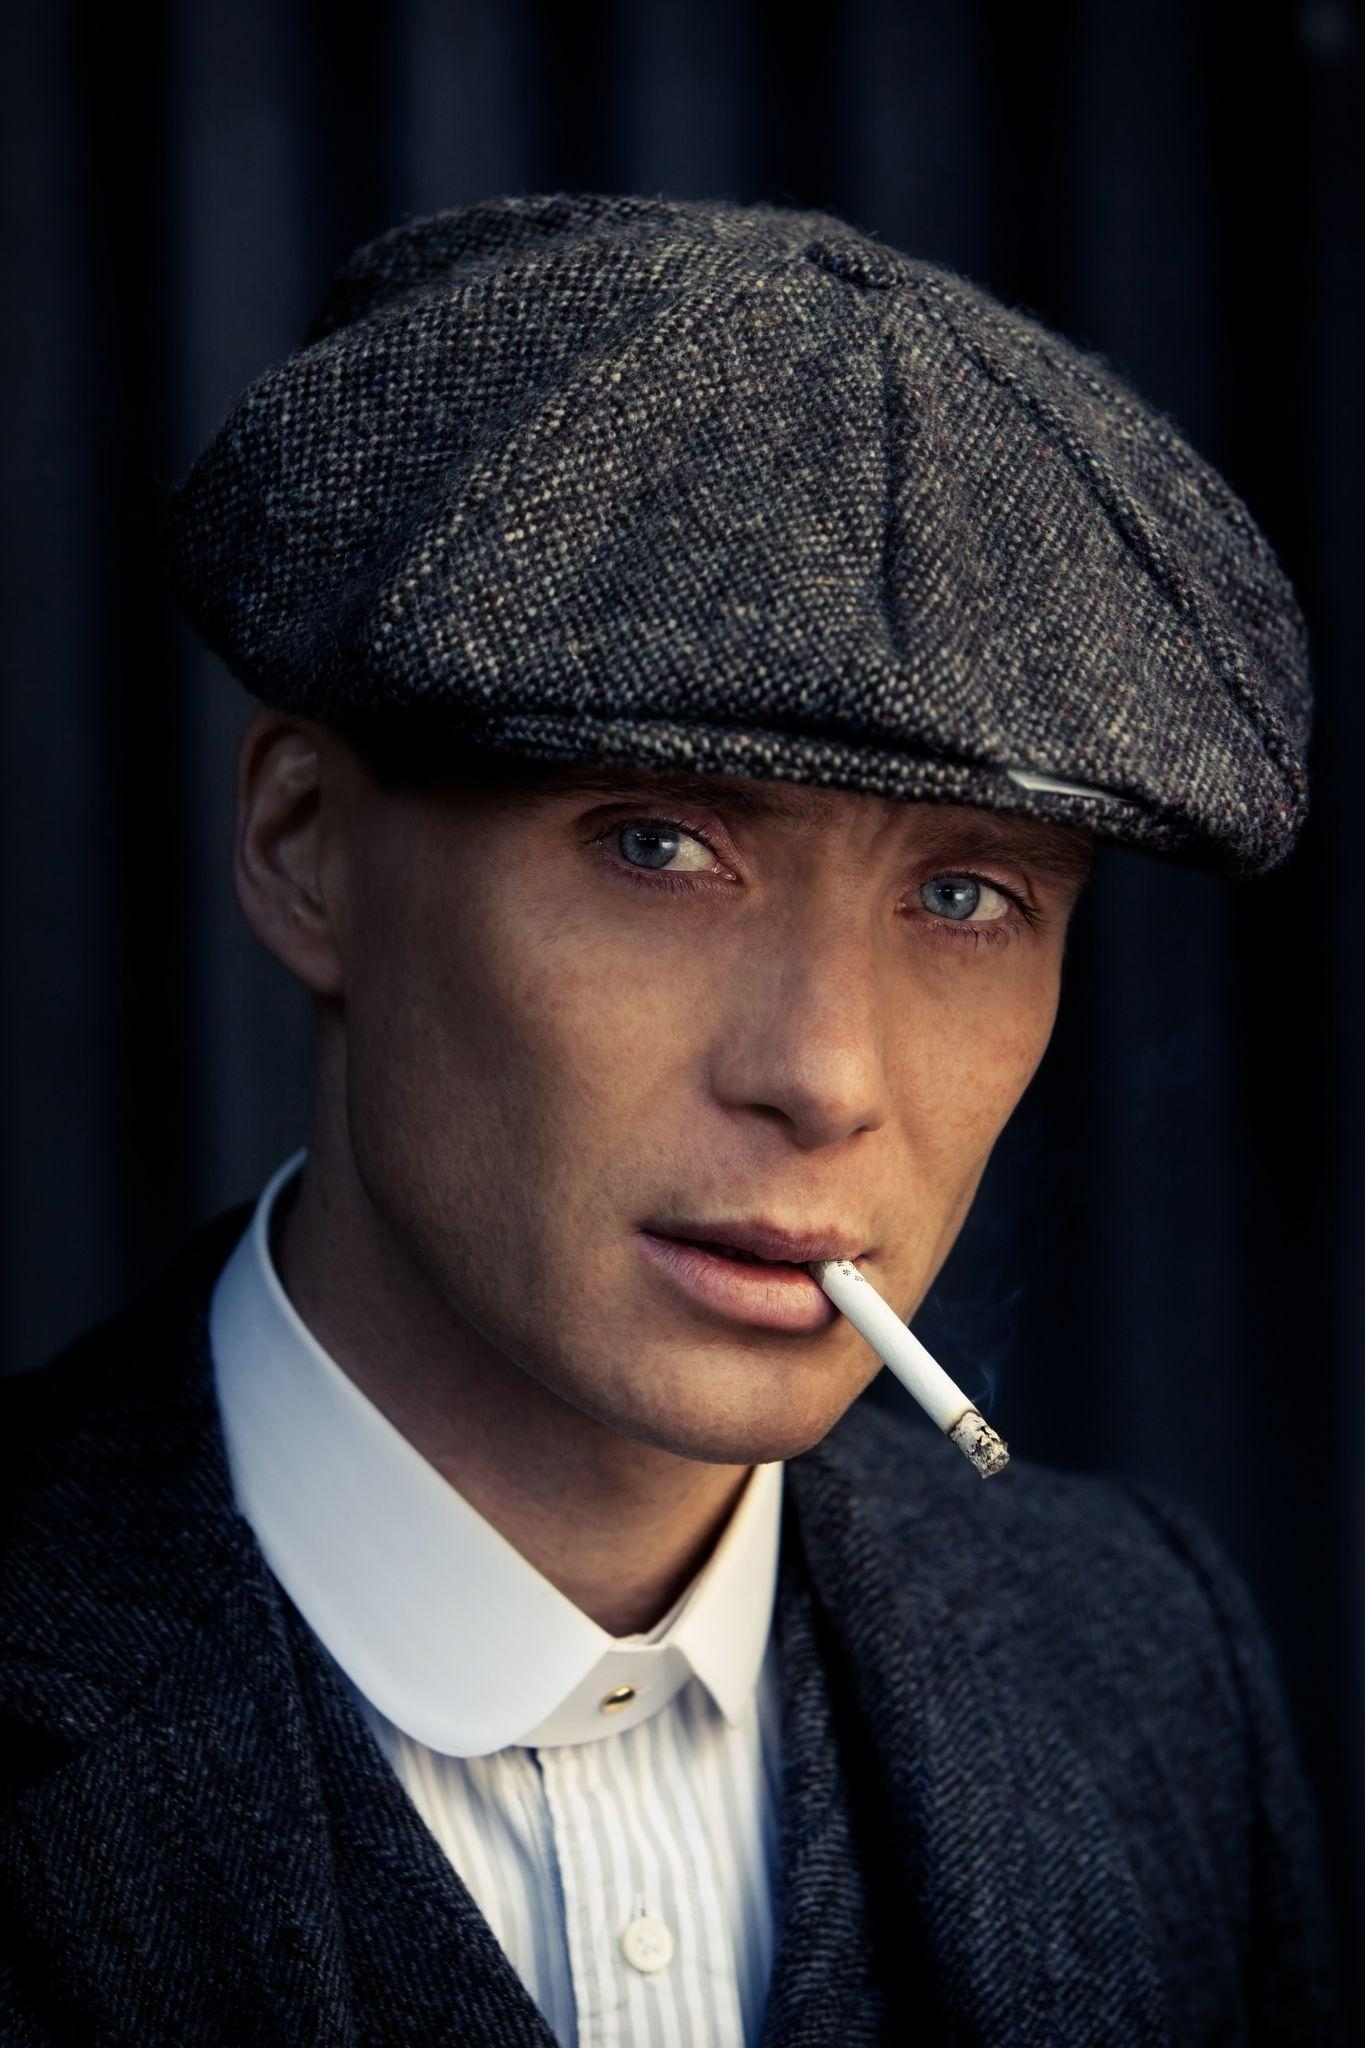

In [133]:
# Load the image

image = Image.open('ThomasShelby3.jpg')
# Simulating a random 1920x2400 colored image (3 channels: RGB)
# 1841 1227
# 1600 900
# 1365 2048

image

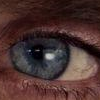

In [134]:

# Define the crop area (left, upper, right, lower)
# For example, to crop a 50x50 segment starting at (1000, 1200)

patch_location_x = 910
patch_location_y = 840

patch_size_x = 100
patch_size_y = 100
crop_area = (patch_location_x, patch_location_y, patch_location_x+patch_size_x, patch_location_y+patch_size_y)

# Crop the image
cropped_image = image.crop(crop_area)
cropped_image2 = image.crop(crop_area)

# Save or display the cropped image
# cropped_image.show()  # To display
cropped_image.save('cropped_image.png')  # To save the cropped image

cropped_image


In [135]:
np_cropped_image = np.array(cropped_image).astype(float)

np.random.seed(42)

# Convert the image to a NumPy array
image_array = np.array(cropped_image) #.astype(float)

# Get image dimensions
height, width = image_array.shape[:2]

# Total number of pixels
total_pixels = height * width

# Set the number of pixels to be removed (N)
N = 900  # Adjust this based on your needs

mask = np.ones(image_array.shape[:2], dtype=bool)

# Generate random indices for the pixels to be removed
random_pixels = random.sample(range(total_pixels), N)

# random_pixels 
# image_array.shape[:2]
# mask


In [149]:

# Convert the 1D indices to 2D coordinates and set them to white
for pixel in random_pixels:
    x = pixel // width  # Row index
    y = pixel % width   # Column index
    
    # Set the pixel to white
    if image_array.ndim == 3:  # For RGB images
        image_array[x, y] = [255, 255, 255]
        mask[x,y] = False
    else:  # For grayscale images
        image_array[x, y] = 255

# Convert the NumPy array back to a PIL image
modified_image = Image.fromarray(image_array)

# Save or display the modified image
modified_image.save('image_with_missing_pixel.png')
# modified_image.show()

# modified_image
# mask
type(image_array)


numpy.ndarray

In [137]:
pixel_missing = np.copy(image_array).astype(float)
pixel_missing[~mask] = np.nan

# pixel_missing

In [201]:

# Parameters
# N = 50  # Patch size
r_values = [5,20,50,100,200]  # Different ranks for low-rank approximation 
# r_values = [5]
learning_rate = 0.000001
iterations = 20000

# Generating a random 50x50 patch for the simulation
np.random.seed(42)

input_image = pixel_missing  # Simulating the image patch
# input_image

In [202]:

# Split the image into R, G, B channels
def getRGB(cropped_image_np):
    R = cropped_image_np[:, :, 0]  # Red channel
    G = cropped_image_np[:, :, 1]  # Green channel
    B = cropped_image_np[:, :, 2]  # Blue channel

    # Now R, G, B are separate 2D arrays representing the color channels
    # print("Red Channel Shape:", R.shape)
    # print("Green Channel Shape:", G.shape)
    # print("Blue Channel Shape:", B.shape)
    
    return R,G,B




In [203]:
def subtract_matrix(P,Z, mask):
    matrix1 = P- Z 
    matrix2 = np.nan_to_num(matrix1, nan=0.0, posinf=255, neginf= 0)
    return matrix2

scale = 1
# Function to perform gradient descent to factorize matrix into W and H
def matrix_factorization(P, r, mask ,lr=learning_rate, iterations=iterations):
    N = P.shape[0]
    # Random initialization of W and H
    W = np.random.rand(N, r)*scale
    H = np.random.rand(r, N)*scale
    # 0.1 multiplied for small random values
    
    for _ in range(iterations):
        # Compute the gradient for W and H
        gradient_W = -2 * (P - W @ H) @ H.T
        gradient_H = -2 * W.T @ (P - W @ H)
        
        Z = W @ H
        gradient_W = -2 * subtract_matrix(P, Z, mask) @ H.T
        gradient_H = -2 * W.T @ subtract_matrix(P, Z, mask)
        
        # Update W and H
        W -= lr * gradient_W
        H -= lr * gradient_H
        
        # W = np.nan_to_num(W, nan=0.0, posinf=255, neginf= 0)
        # H = np.nan_to_num(H, nan=0.0, posinf=255, neginf= 0)
        
        # W = np.clip(W, 0, 255)
        # H = np.clip(H, 0, 255)
    
    return W, H

# mask_array = np.array([[True, False], [True, True]])
# P_array = np.array([[5, np.nan], [6, 7]])
# Z_array = np.array([[4, 3], [2, 1]])


In [204]:
# Prediction Matrix

R,G,B = getRGB(pixel_missing)

# print(R.shape, B.shape)
# R, G

In [205]:

# Evaluate RMSE and PSNR for each r
rmse_values = []
psnr_values = []

height, width = B.shape
reconstructed_patches = []
datatype = B.dtype

for r in r_values:
    # Get the shape of the r, g, b arrays


# Create an empty array with shape (height, width, 3) to hold the RGB image
    reconstructed_patch_np = np.zeros((height, width, 3), dtype= float)

    # Factorize the original patch
    WR, HR = matrix_factorization(R, r, mask)
    WG, HG = matrix_factorization(G, r, mask)
    WB, HB = matrix_factorization(B, r, mask)
    
    # Reconstruct the patch
    reconstructed_patch_R = WR @ HR 
    reconstructed_patch_G = WG @ HG 
    reconstructed_patch_B = WB @ HB 
    
    # Assign the r, g, b arrays to the appropriate channels
    reconstructed_patch_np[:, :, 0] = reconstructed_patch_R  # Red channel
    reconstructed_patch_np[:, :, 1] = reconstructed_patch_G  # Green channel
    reconstructed_patch_np[:, :, 2] = reconstructed_patch_B  # Blue channel
    
    # print(reconstructed_patch_np)
    # reconstructed_patch = Image.fromarray(reconstructed_patch_np)
    # reconstructed_patch.show()
    reconstructed_patches.append(reconstructed_patch_np)
    
    # Compute RMSE
    rmse_value = np.sqrt(mse(np_cropped_image, reconstructed_patch_np))
    rmse_values.append(rmse_value)
    
    # Compute PSNR
    psnr_value = psnr(np_cropped_image, reconstructed_patch_np, data_range=1.0)  # max pixel value is 1.0
    psnr_values.append(psnr_value)


In [206]:
print(type(reconstructed_patches[0]))

<class 'numpy.ndarray'>


In [207]:
print(type(pixel_missing))

<class 'numpy.ndarray'>


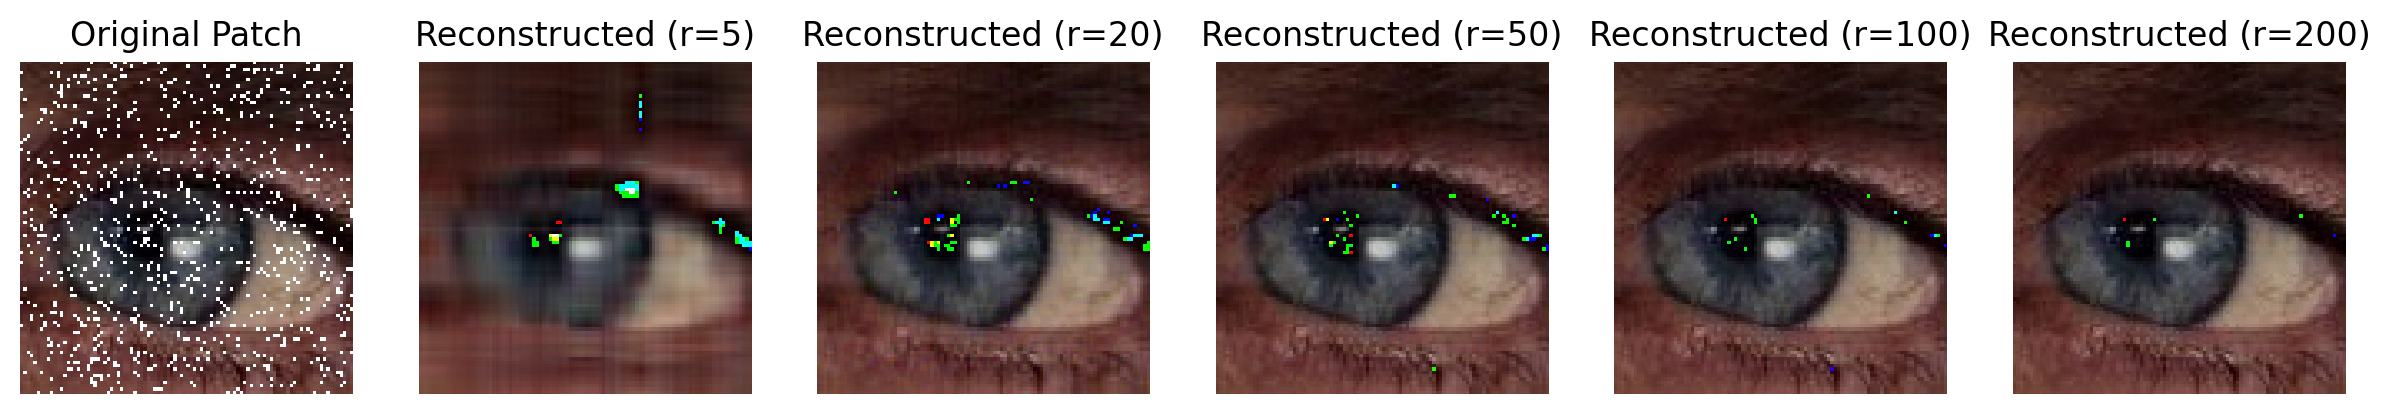

 For r = 5, the RMSE is 11.189, the PSNR is -20.976
 For r = 20, the RMSE is 4.982, the PSNR is -13.949
 For r = 50, the RMSE is 2.9, the PSNR is -9.247
 For r = 100, the RMSE is 2.391, the PSNR is -7.572
 For r = 200, the RMSE is 2.459, the PSNR is -7.815


In [208]:

# Plot original and reconstructed patches
fig, axes = plt.subplots(1, len(r_values) + 1, figsize=(15, 5))
axes[0].imshow(modified_image, cmap='gray')
axes[0].set_title('Original Patch')
axes[0].axis('off')

for i, r in enumerate(r_values):
    getimage = reconstructed_patches[i].astype(np.uint8)
    constructed_image = Image.fromarray(getimage)
    axes[i+1].imshow(constructed_image, cmap='gray')
    axes[i+1].set_title(f'Reconstructed (r={r})')
    axes[i+1].axis('off')

plt.show()

# rmse_values, psnr_values

for i in range(len(r_values)):
    print(f" For r = {r_values[i]}, the RMSE is {round(rmse_values[i], 3)}, the PSNR is {round(psnr_values[i], 3)}")


For r = 5, the RMSE is 11.189, the PSNR is -20.976
 For r = 20, the RMSE is 4.982, the PSNR is -13.949
 For r = 50, the RMSE is 2.9, the PSNR is -9.247
 For r = 100, the RMSE is 2.391, the PSNR is -7.572
 For r = 200, the RMSE is 2.459, the PSNR is -7.815

 


In [ ]:
# lets compare how gaussian kernel does the job 

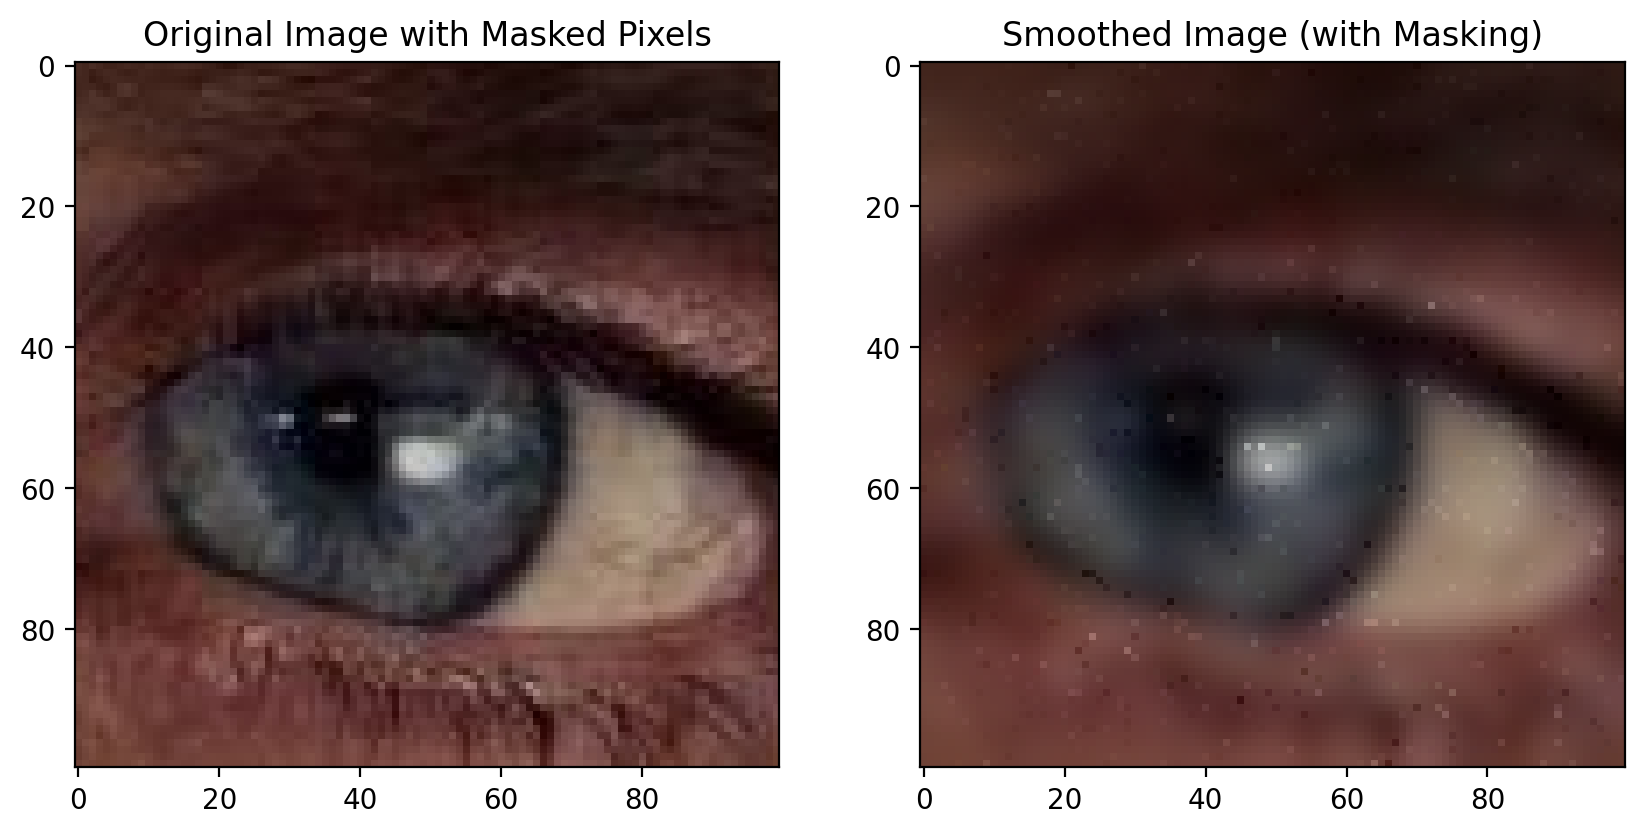

In [220]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

def gaussian_smooth_with_mask(image, mask, sigma):
    """
    Apply Gaussian smoothing to an RGB image, while excluding masked areas.

    :param image: Input RGB image as a (H, W, 3) ndarray
    :param mask: Mask (H, W) where True means "include in smoothing"
    :param sigma: Standard deviation for the Gaussian kernel
    :return: Smoothed image
    """
    
    # Initialize output image
    smoothed_image = np.zeros_like(image)
    
    # Process each channel (R, G, B)
    for i in range(3):
        # Extract the i-th channel
        channel = image[:, :, i]

        # Apply Gaussian filter only to the masked area
        channel_masked = np.where(mask, channel, 0)  # Set unmasked pixels to 0 for filtering
        
        # Apply Gaussian filter to the channel
        filtered = scipy.ndimage.gaussian_filter(channel_masked, sigma=sigma)
        
        # Normalize the Gaussian output based on the mask, avoiding the influence of masked pixels
        mask_blur = scipy.ndimage.gaussian_filter(mask.astype(float), sigma=sigma)
        smoothed_channel = np.where(mask, filtered / (mask_blur + 1e-8), channel)  # Avoid division by zero

        # Store the smoothed channel in the output
        smoothed_image[:, :, i] = smoothed_channel

    return smoothed_image

# Load an example RGB image (here using random data as a placeholder)
image = np_cropped_image
image = image.astype(np.uint8)

# Create a mask where False represents "missing pixels"
# mask = np.ones((100, 100), dtype=bool)
# mask[30:50, 30:50] = False  # Example: block of missing pixels

# Apply Gaussian smoothing with a given sigma value
sigma = 2  # Gaussian kernel standard deviation
smoothed_image = gaussian_smooth_with_mask(image, mask, sigma)

# Plot original and smoothed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image with Masked Pixels")

plt.subplot(1, 2, 2)
plt.imshow(smoothed_image.astype(np.uint8))
plt.title("Smoothed Image (with Masking)")

plt.show()



In [222]:

# rmse_values, psnr_values
# Compute RMSE
rmse_value = np.sqrt(mse(np_cropped_image, smoothed_image))

# Compute PSNR
psnr_value = psnr(np_cropped_image, smoothed_image, data_range=1.0)  # max pixel value is 1.0

print(f" the RMSE is {round(rmse_value, 3)}, the PSNR is {round(psnr_value, 3)}")


 the RMSE is 9.244, the PSNR is -19.317
